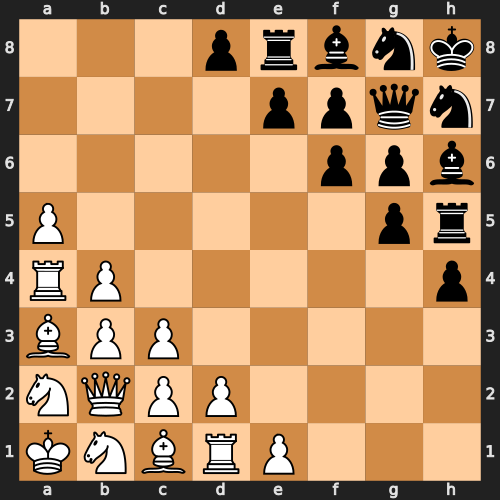

In [34]:
import chess_engine
from chess_engine.diagchess import get_legal_moves_mask 
import random
import matplotlib.pyplot as plt
import numpy as np

env = chess_engine.DiagonalChess()
env.reset()
env.render()

In [35]:
# import modelu
import tensorflow as tf

MODEL_NAMES = {
    "v6-5": "../retain/chess_v6.0_20230608-075209_21500.h5",
    "v6-30": "../retain/chess_v6.0_20230610-072456_1500.h5",
    "v4-1": "../retain/chess_v4.0_20230528-114544_31500.h5",
    "v4-2": "../retain/chess_v4.0_20230527-105139_38000.h5",
    "v4-3": "../retain/chess_v4.0_20230525-231506_107750.h5",
    "v4-4": "../retain/chess_v4.0_20230524-144258_19750.h5",
}

class ChessAgent:
    def __init__(self, model_name):
        self.model = tf.keras.models.load_model(MODEL_NAMES[model_name])
    
    def action_probs(self, state, legal_actions):
        Q_values, critic = self.get_raw(state)
        Q_values = Q_values*legal_actions
        Q_values = Q_values/np.sum(Q_values)

        return Q_values, critic
    
    def get_raw(self, state):
        Q_values, critic = self.model.predict(state[np.newaxis], verbose=0) #type: ignore
        return Q_values[0], critic[0][0]

    def action(self, state, legal_actions):
        actions_prob, _ = self.action_probs(state, legal_actions)

        return np.argmax(actions_prob)
    
def legal_moves(board: chess_engine.DiagonalChess):
    return chess_engine.internal.get_legal_moves_mask(board.board, board.isBlack)

In [36]:
# ten agent zawsze gra białymi
ai_agent = ChessAgent("v6-30")

1. (3, 6, 5, 6)
2. (4, 7, 5, 7)
3. (3, 6, 3, 4)
4. (0, 3, 1, 3)


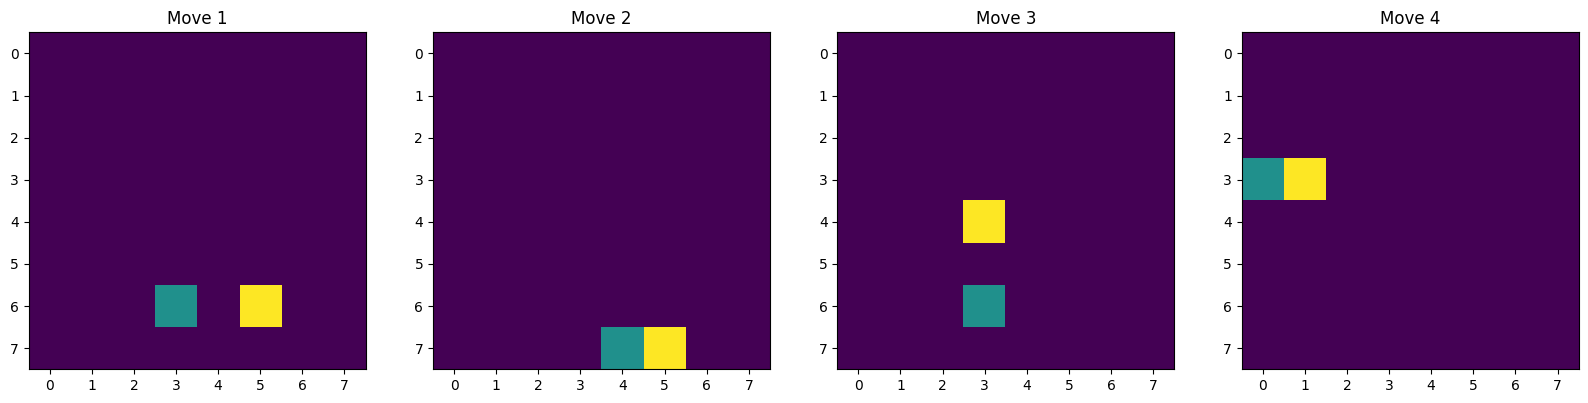

In [37]:
state = env.reset()
probs, critic = ai_agent.action_probs(state, legal_moves(env))

# find best moves
best_moves = np.argsort(probs)[::-1]
best_moves = best_moves[:10]

from chess_engine.diagchess import int_action_to_move

for i, move in enumerate(best_moves[:4]):
    print(f"{i+1}. {int_action_to_move(move)}")

best_moves_imgs = np.zeros((8, 8, 4), dtype=np.uint8)

for i, move in enumerate(best_moves[:4]):
    fromX, fromY, toX, toY = int_action_to_move(move)
    
    best_moves_imgs[fromY, fromX, i] = 128
    best_moves_imgs[toY, toX, i] = 255


fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax[i].imshow(best_moves_imgs[:,:,i])
    ax[i].set_title(f"Move {i+1}")

In [38]:
# moves probabilities with ids
for i, move in enumerate(best_moves):
    print(f"{i+1}. {int_action_to_move(move)}: {probs[move]:.2f}")

1. (3, 6, 5, 6): 0.11
2. (4, 7, 5, 7): 0.09
3. (3, 6, 3, 4): 0.08
4. (0, 3, 1, 3): 0.08
5. (0, 3, 0, 1): 0.08
6. (1, 4, 1, 2): 0.08
7. (4, 7, 4, 6): 0.08
8. (4, 7, 6, 7): 0.07
9. (4, 7, 4, 5): 0.06
10. (3, 6, 3, 5): 0.06


Text(0.5, 0, 'Probability')

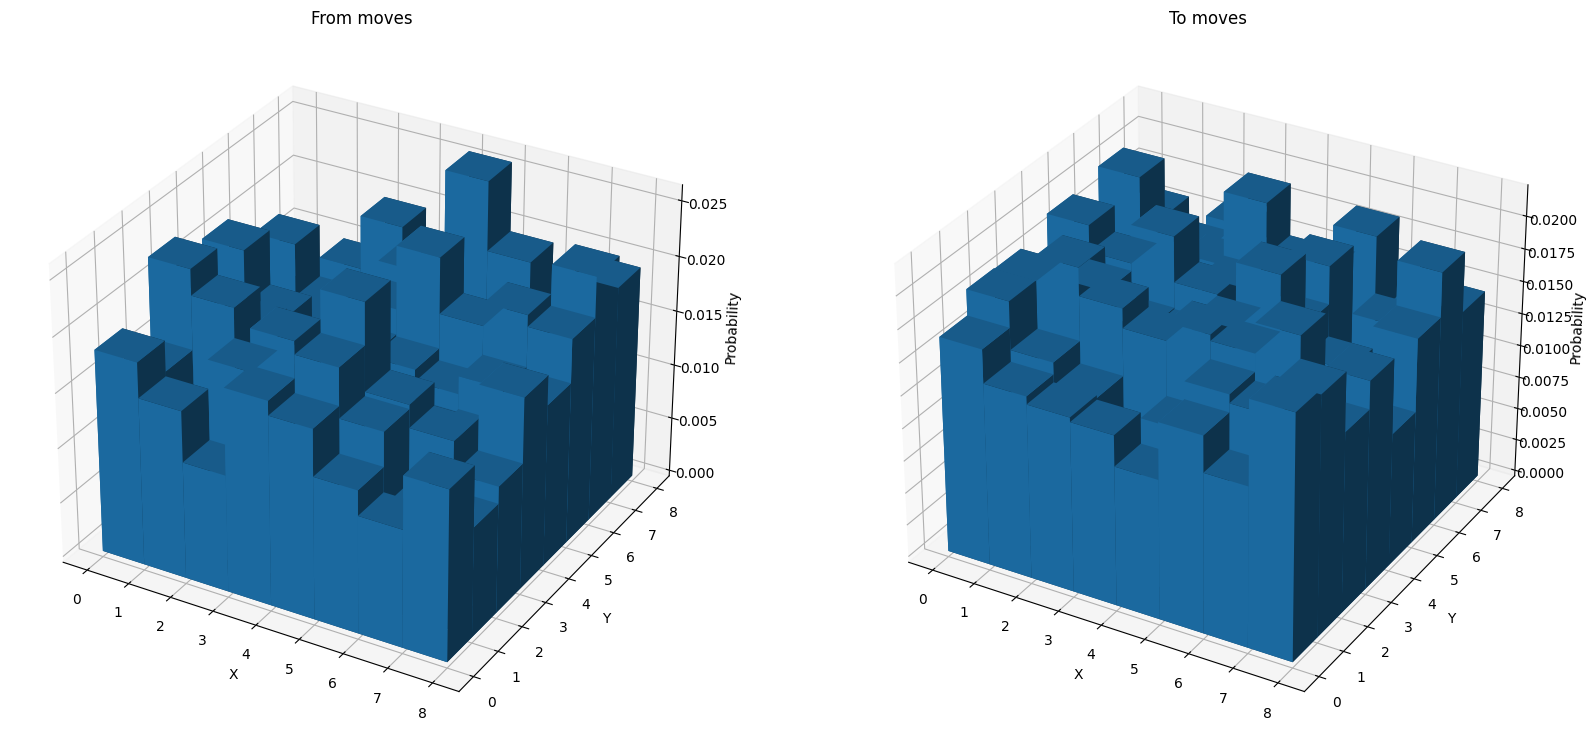

In [63]:
# get raw action
action, critic = ai_agent.get_raw(state)

# normalize
action = action/np.sum(action)

actions = [i for i in range(4096)]

# action to move
moves = [(int_action_to_move(i), action[i]) for i in actions]

# [((0, 0, 0, 0), 0.0009151974), ((0, 0, 0, 1), 0.0006177168), ...

# accumulate moves
from_moves = np.zeros((8, 8), dtype=np.float32)
to_moves = np.zeros((8, 8), dtype=np.float32)

for move, prob in moves:
    fromX, fromY, toX, toY = move
    from_moves[fromY, fromX] += prob
    to_moves[toY, toX] += prob

# plot 3d bar
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')

x = np.arange(8)
y = np.arange(8)
X, Y = np.meshgrid(x, y)

# bar plot
ax.bar3d(X.ravel(), Y.ravel(), np.zeros(64), 1, 1, from_moves.ravel())
ax.set_title("From moves")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Probability")

ax = fig.add_subplot(122, projection='3d')

x = np.arange(8)
y = np.arange(8)
X, Y = np.meshgrid(x, y)

# bar plot
ax.bar3d(X.ravel(), Y.ravel(), np.zeros(64), 1, 1, to_moves.ravel())
ax.set_title("To moves")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Probability")

Text(0.5, 0, 'Probability')

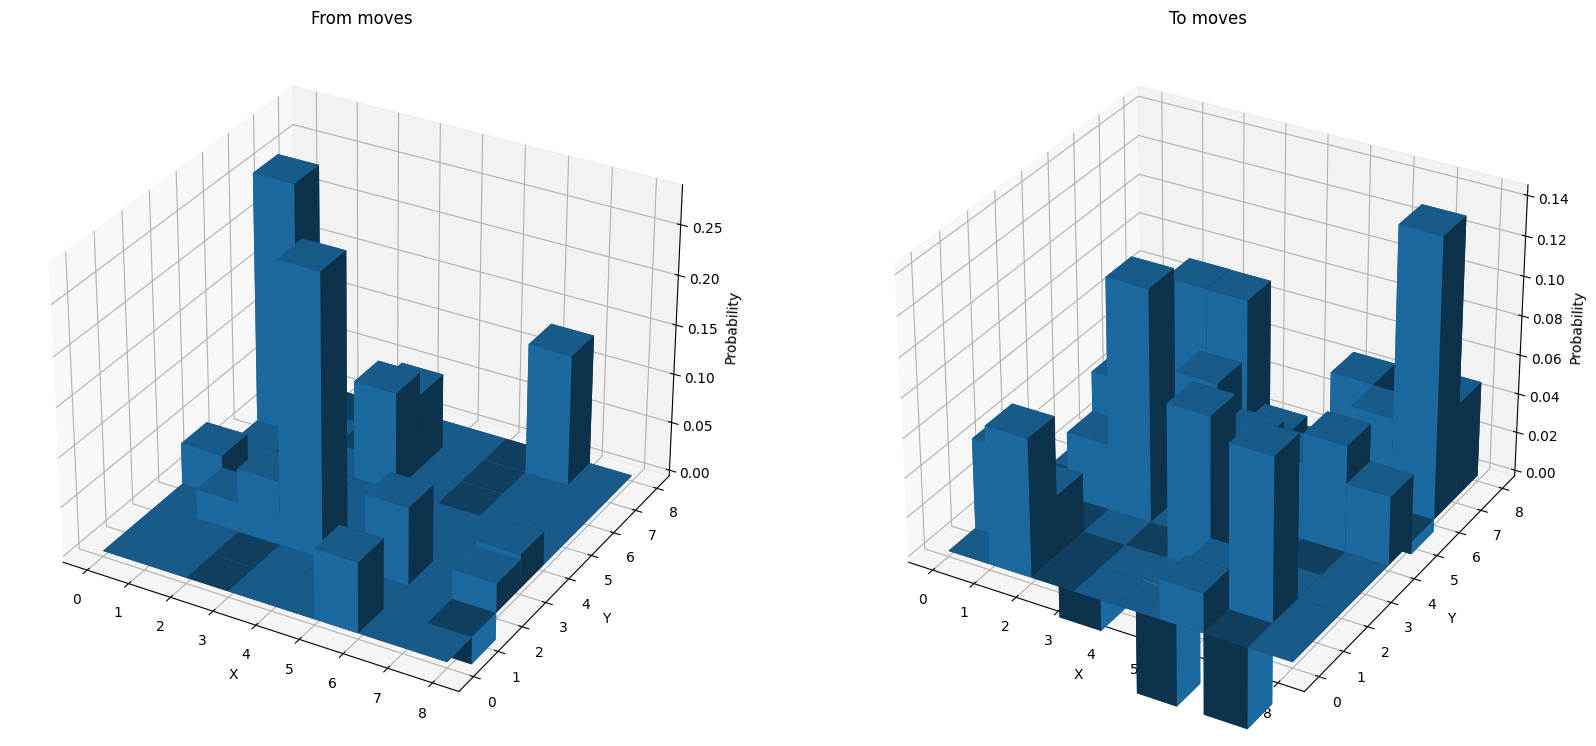

In [64]:
# get raw action
action, critic = ai_agent.get_raw(state)

action = action*legal_moves(env)
# normalize
action = action/np.sum(action)

actions = [i for i in range(4096)]

# action to move
moves = [(int_action_to_move(i), action[i]) for i in actions]

# [((0, 0, 0, 0), 0.0009151974), ((0, 0, 0, 1), 0.0006177168), ...

# accumulate moves
from_moves = np.zeros((8, 8), dtype=np.float32)
to_moves = np.zeros((8, 8), dtype=np.float32)

for move, prob in moves:
    fromX, fromY, toX, toY = move
    from_moves[fromY, fromX] += prob
    to_moves[toY, toX] += prob

# plot 3d bar
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')

x = np.arange(8)
y = np.arange(8)
X, Y = np.meshgrid(x, y)

# bar plot
ax.bar3d(X.ravel(), Y.ravel(), np.zeros(64), 1, 1, from_moves.ravel())
ax.set_title("From moves")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Probability")

ax = fig.add_subplot(122, projection='3d')

x = np.arange(8)
y = np.arange(8)
X, Y = np.meshgrid(x, y)

# bar plot
ax.bar3d(X.ravel(), Y.ravel(), np.zeros(64), 1, 1, to_moves.ravel())
ax.set_title("To moves")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Probability")

In [66]:
from tqdm.notebook import tqdm
N_GAME = 100

rewards = []
games_backtrace = []

#ai_agent = ChessAgent("v4-4")
#ai_agent = ChessAgent("v4-3")
#ai_agent = ChessAgent("v4-2")
ai_agent = ChessAgent("v6-30")
#ai_agent = ChessAgent("v6-5")

t = tqdm(range(N_GAME))
for i in t:
    state = env.reset()
    reward_sum = 0 
    backtrace = []   
    for it in range(15):
        action = ai_agent.action(state, legal_moves(env))
        #action = int((np.random.randn(4096)*legal_moves(env)).argmax())
 
        state1, reward1, done1 = env.step(int(action))

        # make random move
        state2, reward2, done2 = env.step(int(np.random.randint(0, 4096)))

        reward = reward1 - max(reward2, 0)
        state = state2
        done = done1 or done2

        backtrace.append((state, action, reward, done, env.render()))

        if done:
            break
        reward_sum += reward

    avg = np.mean(rewards)
    t.set_description(f"Average reward: {avg:.2f}")
    
    rewards.append(reward_sum)
    games_backtrace.append(backtrace)

print(f"Average reward: {np.mean(rewards)}")
print(f"Max reward: {np.max(rewards)}")
print(f"Min reward: {np.min(rewards)}")
print(f"Std reward: {np.std(rewards)}")


  0%|          | 0/100 [00:00<?, ?it/s]

Average reward: 37.01
Max reward: 70
Min reward: 11
Std reward: 10.622141968548528


Text(0.5, 1.0, 'Reward per game')

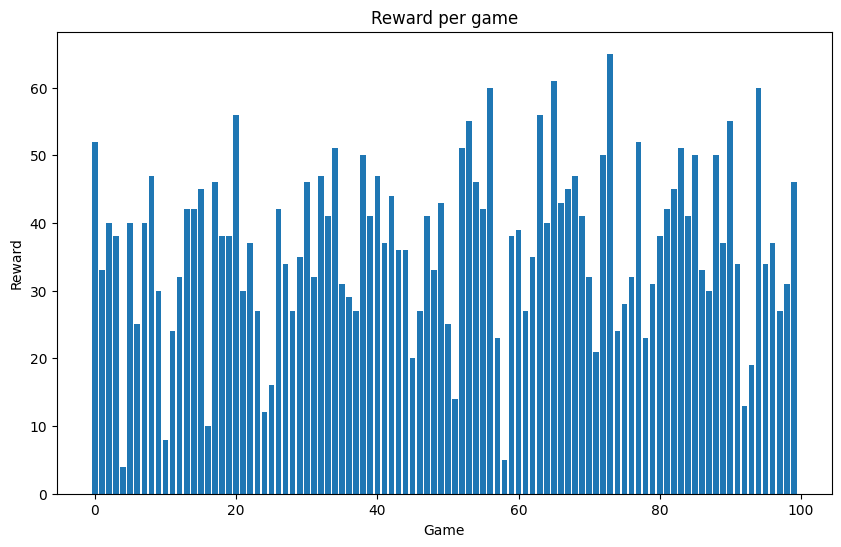

In [48]:
# plot reward bar plot
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(rewards)), rewards)
plt.xlabel("Game")
plt.ylabel("Reward")
plt.title("Reward per game")

Text(0.5, 1.0, 'Histogram of reward: $\\mu=36.73$, $\\sigma=12.53$')

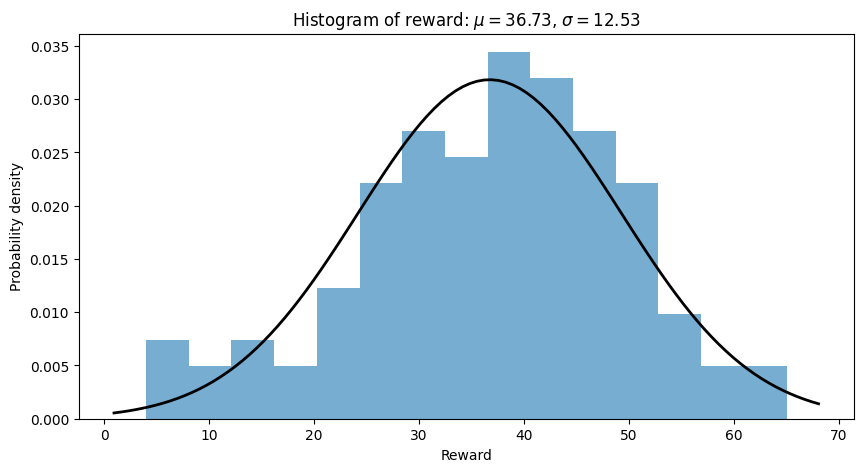

In [49]:
# plot histogram
from scipy.stats import norm

mu, std = norm.fit(rewards) 

ax = plt.figure(figsize=(10, 5)).add_subplot(111)
ax.hist(rewards, bins=15, density=True, alpha=0.6)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)
ax.set_xlabel('Reward')
ax.set_ylabel('Probability density')
ax.set_title(f'Histogram of reward: $\\mu={mu:.2f}$, $\\sigma={std:.2f}$')

Game 73 with reward 65, length: 15
Action: 1966, reward: 1, done: False


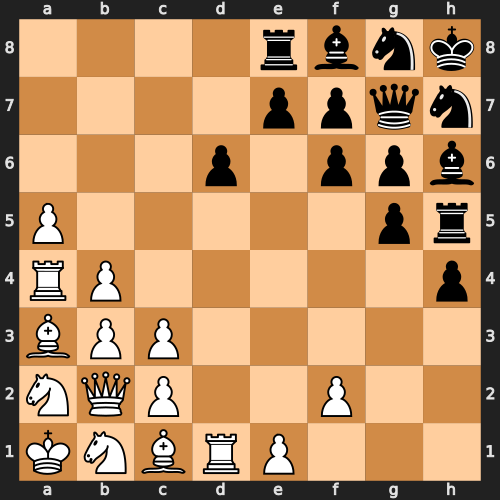

Action: 1523, reward: 6, done: False


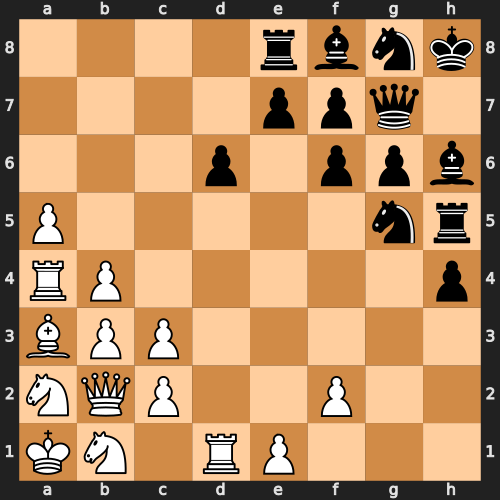

Action: 2012, reward: 1, done: False


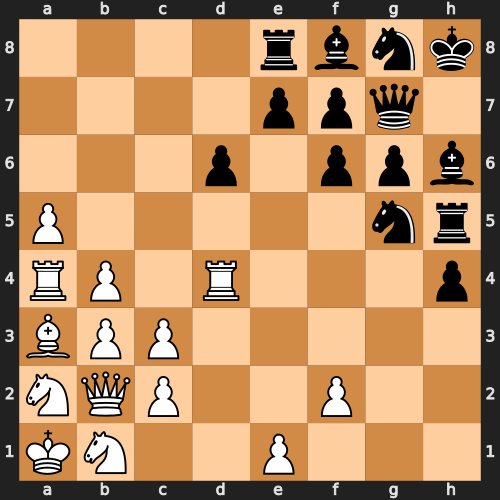

Action: 1818, reward: 6, done: False


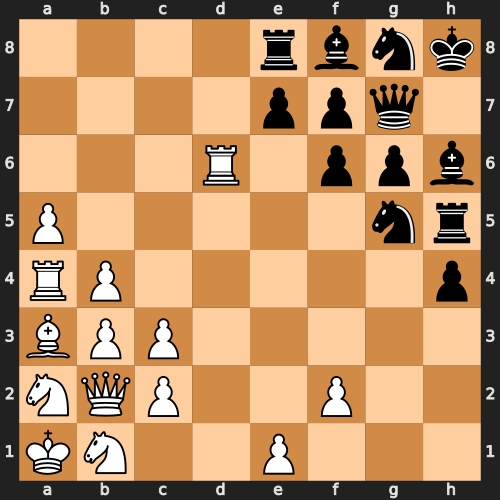

Action: 1674, reward: 1, done: False


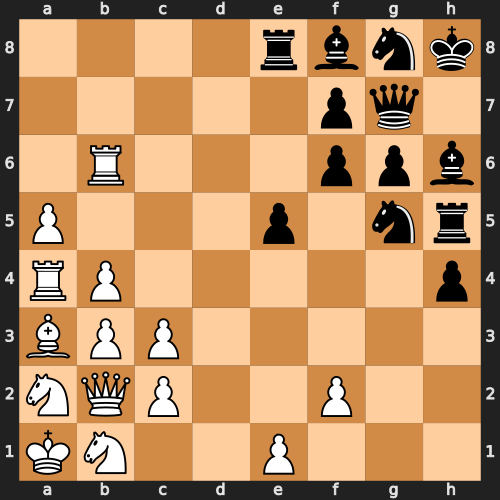

Action: 682, reward: 6, done: False


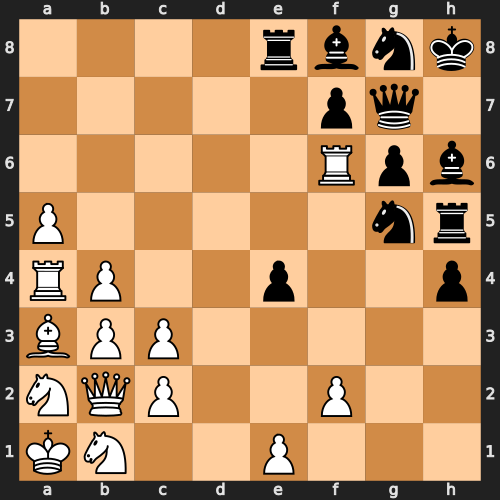

Action: 919, reward: 1, done: False


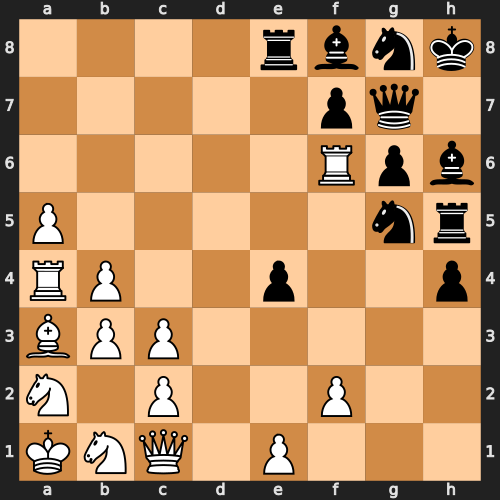

Action: 1523, reward: 6, done: False


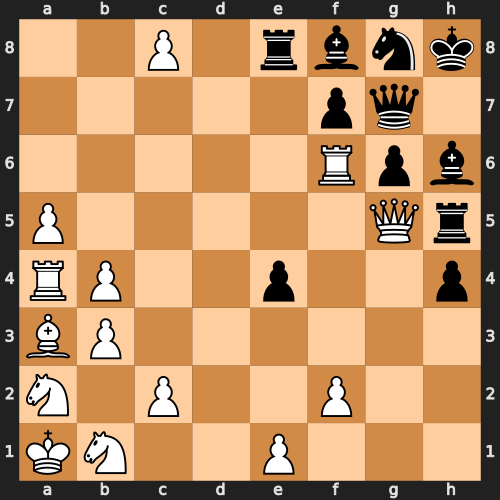

Action: 3322, reward: 6, done: False


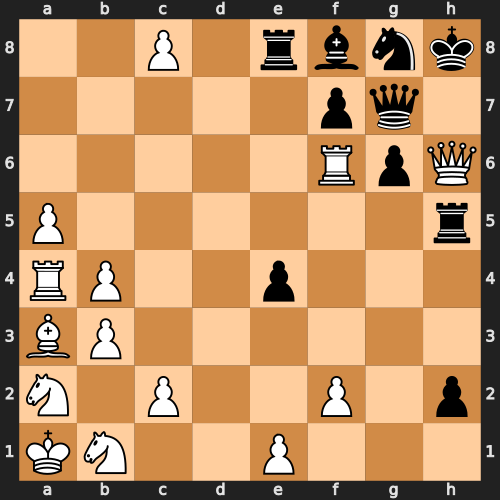

Action: 2729, reward: 6, done: False


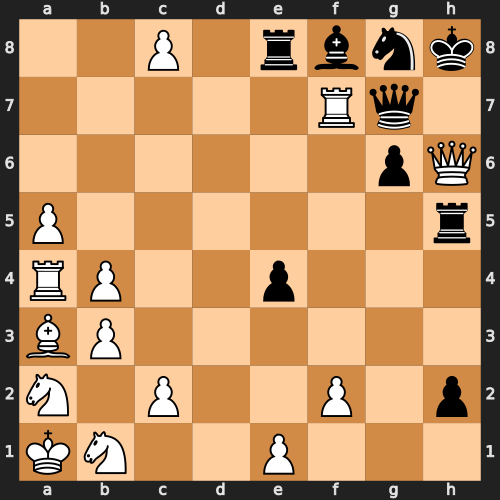

Action: 3761, reward: 6, done: False


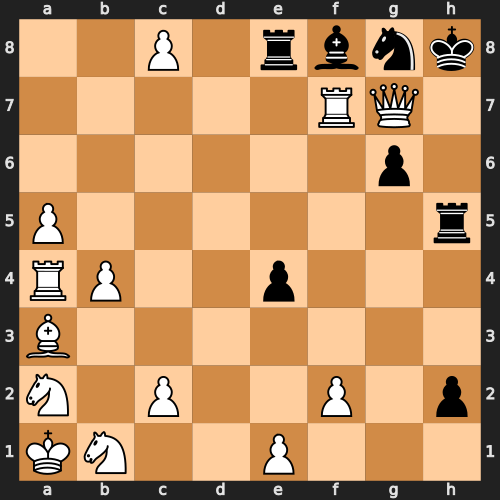

Action: 3186, reward: 6, done: False


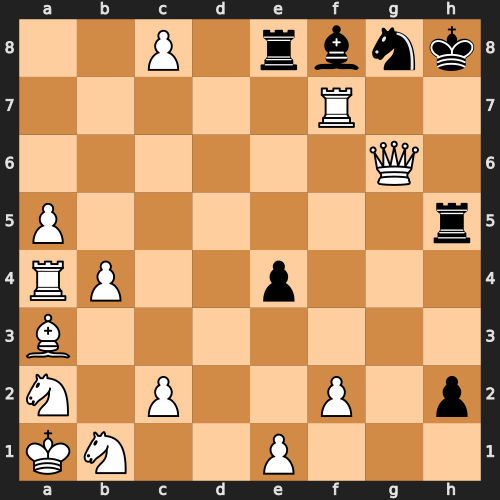

Action: 2664, reward: 6, done: False


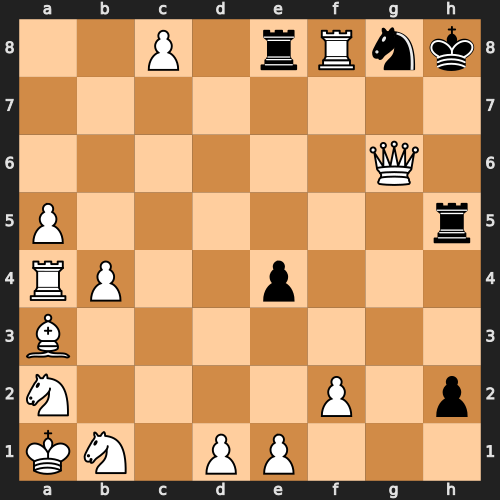

Action: 3248, reward: 6, done: False


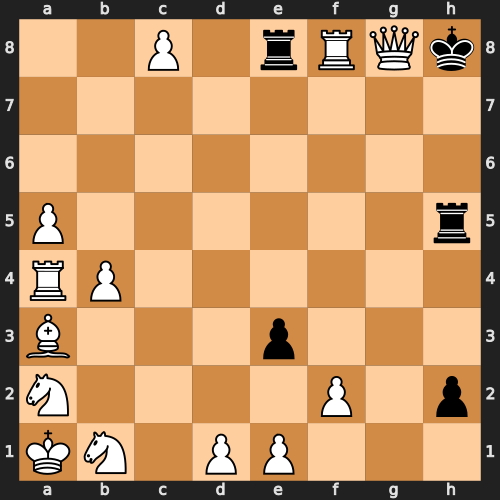

Action: 2989, reward: 1, done: False


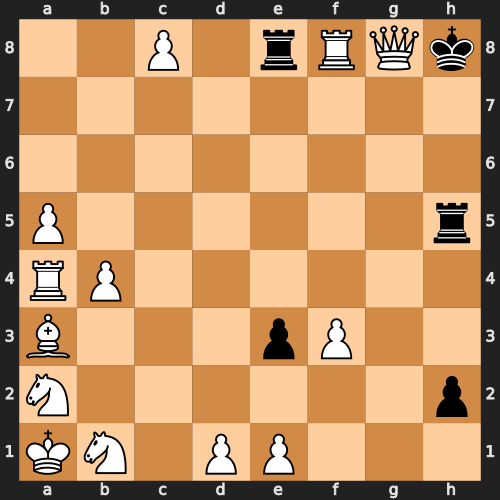

In [50]:
from IPython.display import display

# best game
selected_game = np.argmax(rewards)
game = games_backtrace[selected_game]
print(f"Game {selected_game} with reward {rewards[selected_game]}, length: {len(game)}")

for state, action, reward, done, svg in game:
    print(f"Action: {action}, reward: {reward}, done: {done}")
    display(svg)

Game 18 with reward 38, length: 15
Action: 1966, reward: 1, done: False


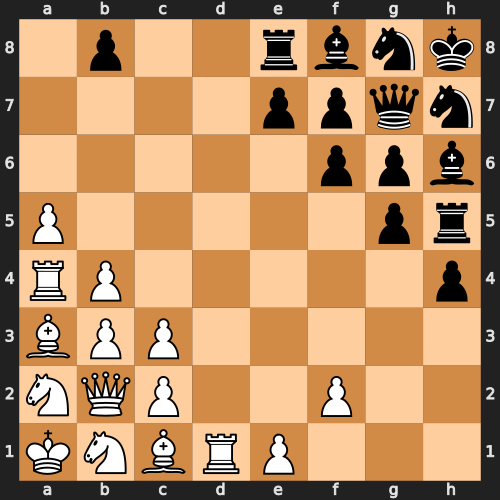

Action: 1523, reward: 2, done: False


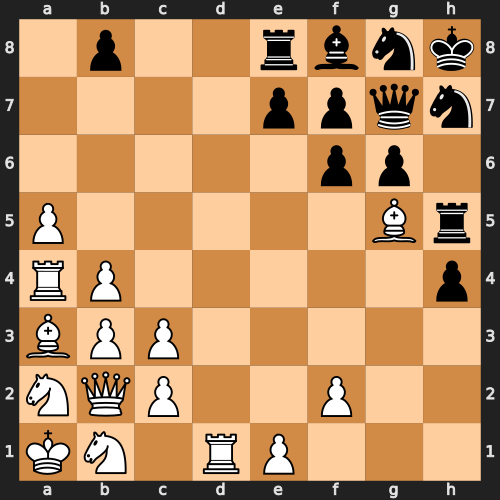

Action: 3306, reward: 6, done: False


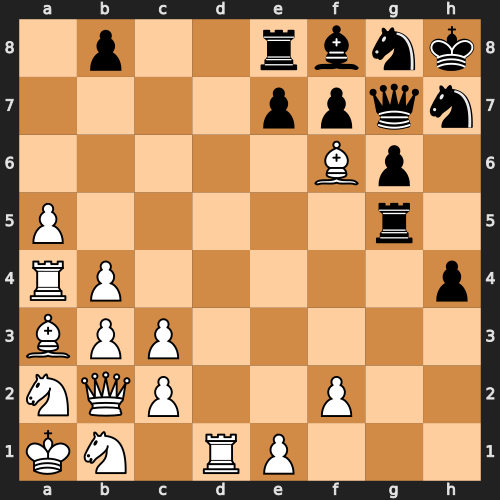

Action: 2008, reward: 1, done: False


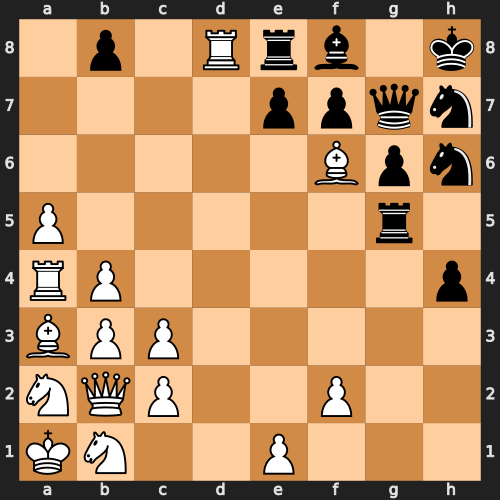

Action: 919, reward: 1, done: False


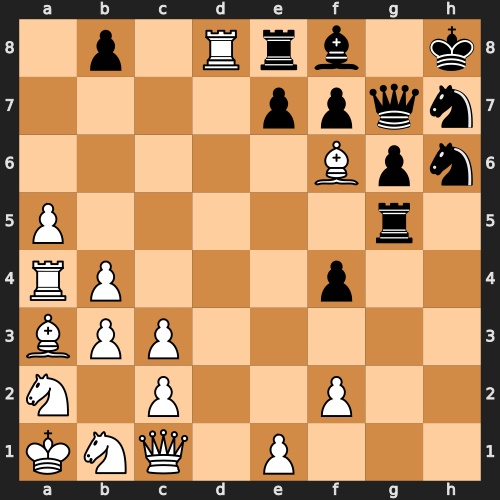

Action: 2543, reward: 1, done: False


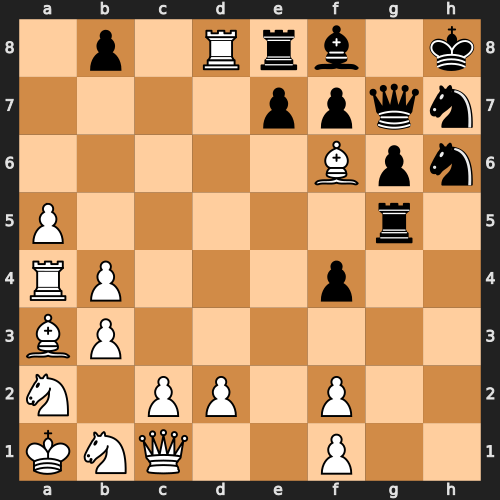

Action: 2737, reward: 6, done: False


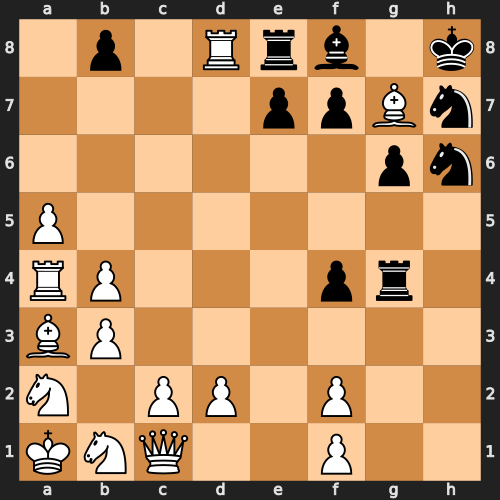

Action: 779, reward: 1, done: False


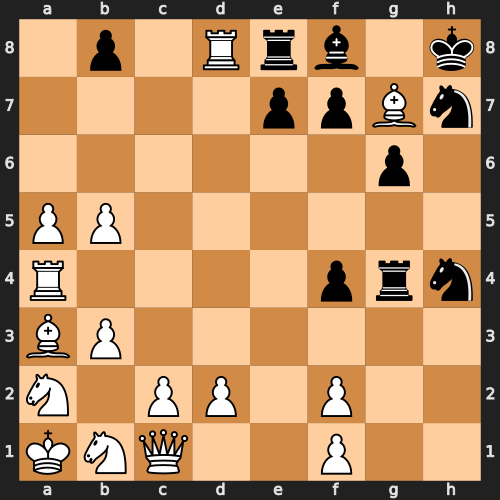

Action: 2989, reward: -3, done: False


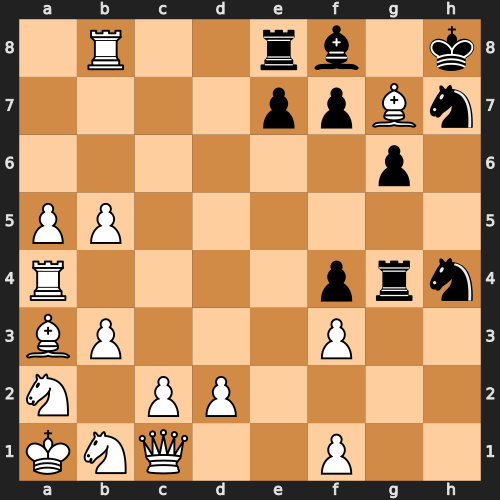

Action: 544, reward: 6, done: False


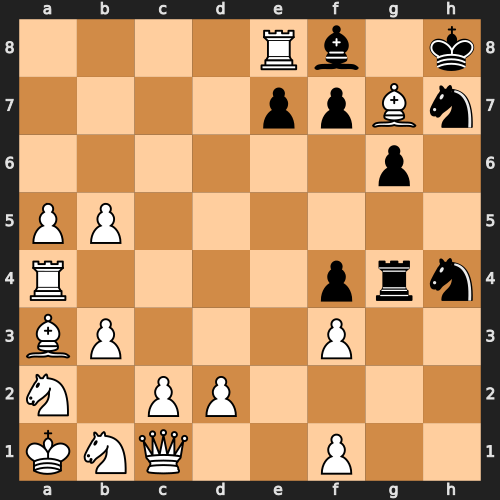

Action: 353, reward: 6, done: False


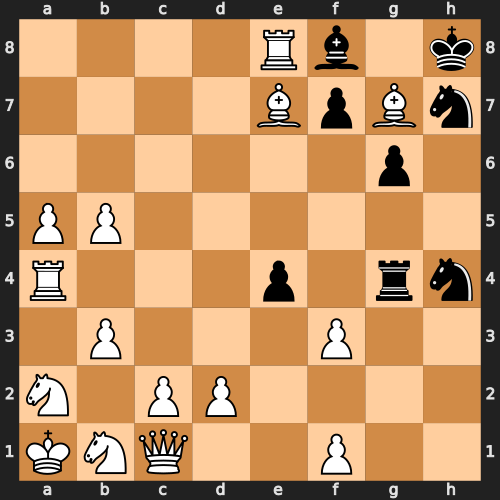

Action: 2152, reward: 6, done: False


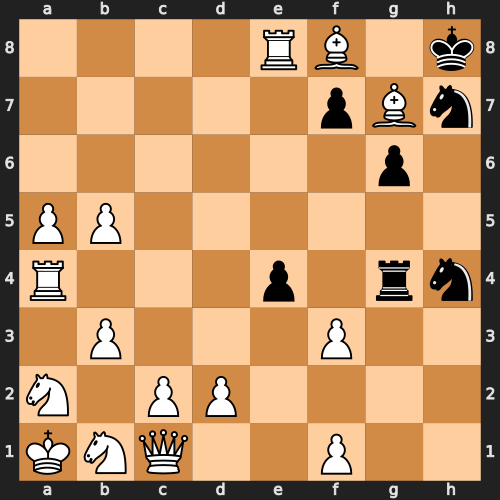

Action: 1966, reward: 1, done: False


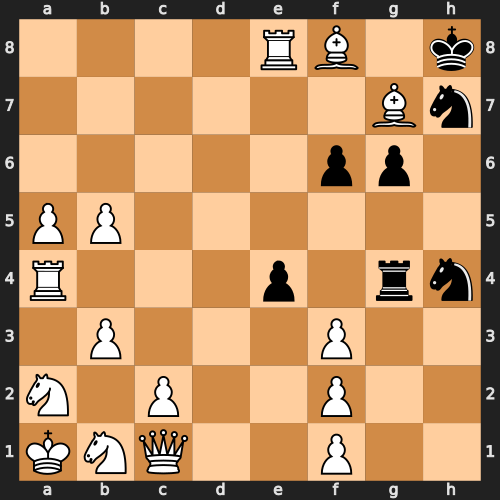

Action: 981, reward: 1, done: False


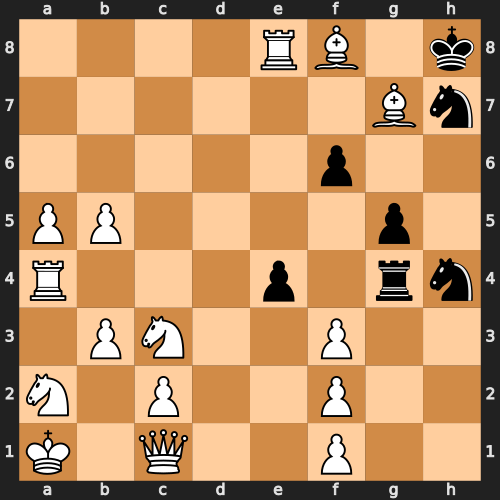

Action: 1523, reward: 2, done: False


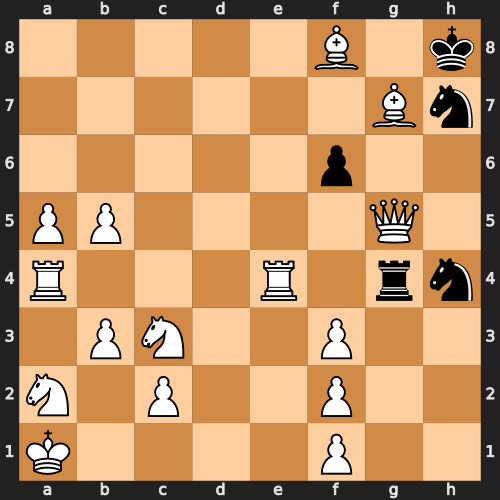

In [52]:
# median game
selected_game = np.argsort(rewards)[len(rewards)//2]
game = games_backtrace[selected_game]

print(f"Game {selected_game} with reward {rewards[selected_game]}, length: {len(game)}")

for state, action, reward, done, svg in game:
    print(f"Action: {action}, reward: {reward}, done: {done}")
    display(svg)
    

Text(0, 0.5, 'Y')

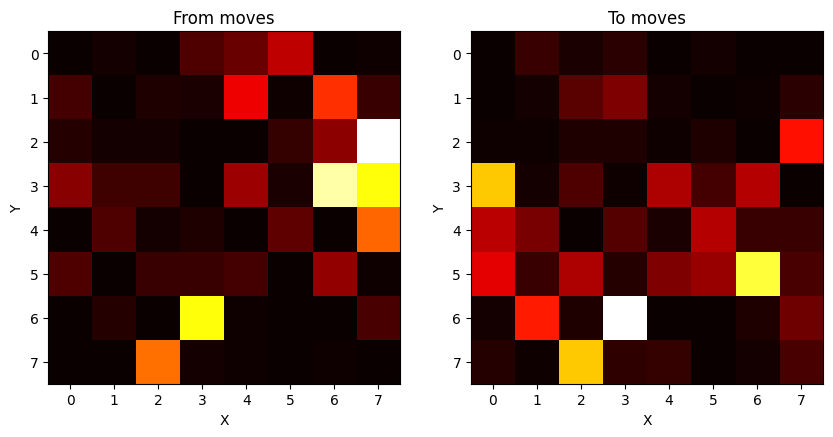

In [45]:
# accumulate the average moves for all games
from_moves = np.zeros((8, 8))
to_moves = np.zeros((8, 8))

for game in games_backtrace:
    for state, action, reward, done, svg in game:
        # transform actions to moves
        move = int_action_to_move(action)


        # accumulate moves
        from_moves[move[0], move[1]] += 1
        to_moves[move[2], move[3]] += 1
        
            
# normalize
from_moves = from_moves / (np.sum(from_moves)+1e-6)
to_moves = to_moves / (np.sum(to_moves)+1e-6)

# plot heatmap of moves, two subplots using plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.imshow(from_moves, cmap='hot', interpolation='nearest')
ax1.set_title('From moves')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

ax2.imshow(to_moves, cmap='hot', interpolation='nearest')
ax2.set_title('To moves')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
